## Challenge 1 

## Instructions
Predict the types of the creatures described in the ‘test.csv’ file and submit them in the ‘sample_submission.csv’ 

## Data fields
*	id - id of the creature
*	bone_length - average length of bone in the creature, normalized between 0 and 1
*	rotting_flesh - percentage of rotting flesh in the creature
*	hair_length - average hair length, normalized between 0 and 1
*	has_soul - percentage of soul in the creature
*	color - dominant color of the creature: 'white','black','clear','blue','green','blood'
*	type - target variable: 'Ghost', 'Goblin', and 'Ghoul'

## Evaluation
Submissions are evaluated on the categorization accuracy (the percent of creatures that you correctly classify).

## Submission File
Your submission file should predict the type for each creature in the test set. The file should contain a header.




## Step 1: Data extraction

In [31]:
#data preprocessing
import pandas as pd

#produces a prediction model in the form of an ensemble of weak prediction models, typically decision tree
import xgboost as xgb
#the outcome (dependent variable) has only a limited number of possible values. 
#Logistic Regression is used when response variable is categorical in nature.
from sklearn.linear_model import LogisticRegression
#A random forest is a meta estimator that fits a number of decision tree classifiers 
#on various sub-samples of the dataset and use averaging to improve the predictive 
#accuracy and control over-fitting.
from sklearn.ensemble import RandomForestClassifier
#a discriminative classifier formally defined by a separating hyperplane.
from sklearn.svm import SVC
#Neural network classifier
from sklearn.neural_network import MLPClassifier
#
from sklearn.ensemble import RandomForestClassifier
#
from sklearn.tree import DecisionTreeClassifier
#Selecting best_param for a model
from sklearn.model_selection import GridSearchCV
#displayd data
from IPython.display import display
%matplotlib inline



In [32]:
#First we import dependencies 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#Read data and merge files
sizes=pd.read_csv("C:/Users/Amine/Desktop/Amine/Data science/Data Science 20182019/Machine learning challenge/sizes.csv", delimiter=",")
colors=pd.read_csv("C:/Users/Amine/Desktop/Amine/Data Science/Data Science 20182019/Machine learning challenge/colors.csv", delimiter=",")
types=pd.read_csv("C:/Users/Amine/Desktop/Amine/Data Science/Data Science 20182019/Machine learning challenge/types.csv", delimiter=",")

dataset=pd.merge(sizes,colors)
dataset=pd.merge(dataset,types)

#Type of data
dataset.dtypes

#Convert object type into str
dataset['type']=dataset['type'].astype('str')
dataset['color']=dataset['color'].astype('str')

#Preview dataset
display(dataset.head())

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,858,0.440432,0.309498,0.203057,0.194105,clear,Ghost
1,775,0.571056,0.729873,0.421166,0.785423,clear,Ghoul
2,714,0.440998,0.234051,0.576912,0.509368,white,Goblin
3,216,0.341539,0.689139,0.313948,0.055464,black,Ghost
4,266,0.489132,0.481304,0.482691,0.460081,white,Goblin


In [33]:
#We observe that one input column of our prediction model is an object which we have to convert into numeric variable
#We 'll use the One versus all method which let us avoid to add a order relation between the variable
#The n class classification problem is converted into a n binary class classification problem 

#We'll add one column for each categories of the column 'color' and drop it
dummy_color = pd.get_dummies(dataset["color"], prefix="col")
dataset = pd.concat([dataset, dummy_color], axis=1)
dataset=dataset.drop(['color'],axis=1)

#Preview dataset
display(dataset.head())

,id,bone_length,rotting_flesh,hair_length,has_soul,type,col_black,col_blood,col_blue,col_clear,col_green,col_white
0,858,0.440432,0.309498,0.203057,0.194105,Ghost,0,0,0,1,0,0
1,775,0.571056,0.729873,0.421166,0.785423,Ghoul,0,0,0,1,0,0
2,714,0.440998,0.234051,0.576912,0.509368,Goblin,0,0,0,0,0,1
3,216,0.341539,0.689139,0.313948,0.055464,Ghost,1,0,0,0,0,0
4,266,0.489132,0.481304,0.482691,0.460081,Goblin,0,0,0,0,0,1


In [34]:
############################################### Step 2: Data Analysis ###############################################
stats=dataset.describe()#data are normalized so it is useless
#Total number of rows
numb_rows=dataset.shape[0]

#Total number of Class and frequencies
freq_class=dataset['type'].value_counts()



print("Number of rows: {}".format(numb_rows))
print ("Frequencies of Class : {}".format(freq_class))



Number of rows: 271
Frequencies of Class : Ghost     93
Ghoul     91
Goblin    87
Name: type, dtype: int64


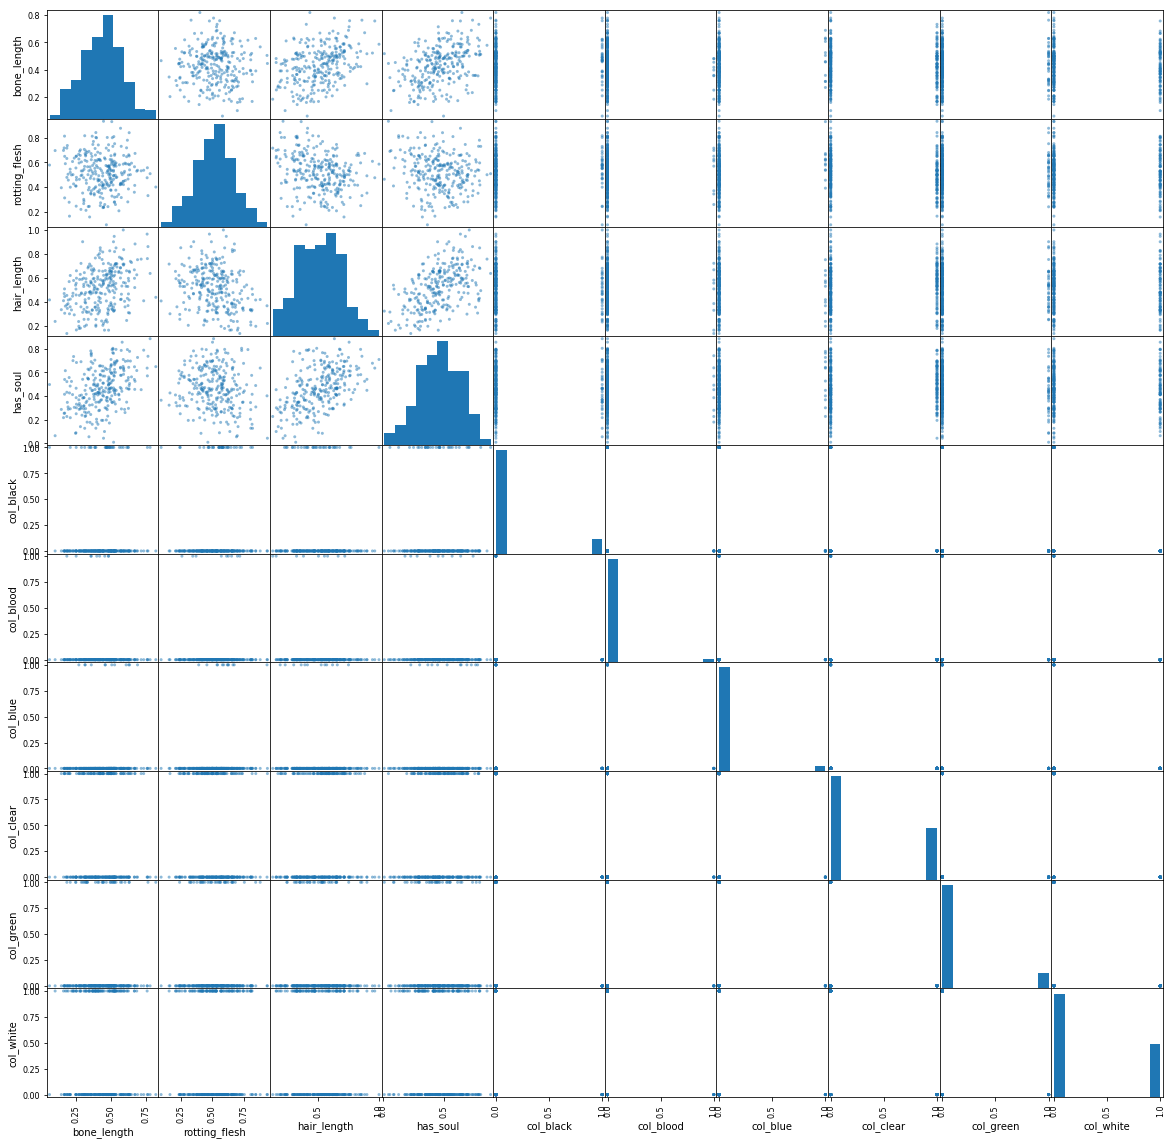

In [35]:
#Visualizing distribution of data 
from pandas.plotting import scatter_matrix

#The scatter matrix is plotting each of the columns specified against each other column.
#Scatter plots  show us the correlation between two variables, negative vs positive correlation

scatter_matrix(dataset[['bone_length','rotting_flesh','hair_length','has_soul','type','col_black','col_blood','col_blue','col_clear','col_green','col_white']],figsize=(20,20))
plt.show()

# Preparing the Datatset for prediction

In [36]:
#Separate into feature set and target variable

X_all= dataset.drop(['type'],1)
Y_all = dataset['type']





# Training and Evaluating Models

# F1 score (also F-score or F-measure) is a measure of a test's accuracy. 
It considers both the precision p and the recall r of the test to compute 
the score: p is the number of correct positive results divided by the number of 
all positive results, and r is the number of correct positive results divided by 
the number of positive results that should have been returned. The F1 score can be 
interpreted as a weighted average of the precision and recall, where an F1 score 
reaches its best value at 1 and worst at 0.

* The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives.    The recall is intuitively the ability of the classifier to find all the positive samples.(sklearn_documentation)

* F1 = 2 * (precision * recall) / (precision + recall)

In [37]:
#for measuring training time
from time import time 

from sklearn.metrics import f1_score

def train_classifier(clf, X_train, y_train,param_grid):
    '''Fits a classifier to the training data'''
    
    #Start the clock, train the classifier, then stop the clock
    start=time()
    clf=GridSearchCV(clf, param_grid, cv=4,scoring='accuracy')
    clf.fit(X_train, y_train)
    end = time()
    
    #Print the results
    print(("Trained model in {:.4f} seconds".format(end-start)))
    return clf
    
def predict_labels(clf, features, target):
    '''Makes the prediction using a fit classifier based on F1 score'''
    
    #start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    #Print and return results
    print("Made predictions in {:.4f} seconds".format(end-start))
    
    return f1_score(target, y_pred, average='weighted'), sum(target==y_pred)/float(len(y_pred))

def train_predict(clf, X_train, y_train, X_test, y_test,param_grid={}):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print ("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)))
    
    # Train the classifier
    clf=train_classifier(clf, X_train, y_train,param_grid)
    
    # Print the results of prediction for both training and testing
    f1, acc = predict_labels(clf, X_train, y_train)
    print ("F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc))
    
    f1, acc = predict_labels(clf, X_test, y_test)
    print ("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc))
    return acc


In [38]:
from sklearn.cross_validation import train_test_split

# Shuffle and split the dataset into training and testing set
scores_array=[]

for i in range(10):
    row_scores_array=[]
    X_train, X_test, y_train, y_test = train_test_split(X_all, Y_all, 
                                                    test_size = 0.30,
                                                    random_state = i,
                                                    stratify = Y_all)

    # Initialize the six models (XGBoost is initialized later)
    clf_A = LogisticRegression(random_state = 42)
    clf_B = SVC(random_state = 912, kernel='linear')
    #Boosting refers to this general problem of producing a very accurate prediction rule 
    #by combining rough and moderately inaccurate rules-of-thumb
    clf_C = xgb.XGBClassifier(seed = 82)
    clf_D=MLPClassifier()
    clf_E=DecisionTreeClassifier()
    clf_F=RandomForestClassifier()
    
    row_scores_array.append(train_predict(clf_A, X_train, y_train, X_test, y_test,param_grid={}))
    print ('')
    row_scores_array.append(train_predict(clf_B, X_train, y_train, X_test, y_test,param_grid={}))
    print ('')
    row_scores_array.append(train_predict(clf_C, X_train, y_train, X_test, y_test,param_grid={}))
    print(clf_C.get_params())
    print ('')
    row_scores_array.append(train_predict(clf_D, X_train, y_train, X_test, y_test,param_grid={}))
    print ('')
    row_scores_array.append(train_predict(clf_E, X_train, y_train, X_test, y_test,param_grid={}))
    print ('')
    row_scores_array.append(train_predict(clf_F, X_train, y_train, X_test, y_test,param_grid={}))
    print ('')
    
    scores_array.append(row_scores_array)
    print("################################################################################ {}".format(i))

Training a LogisticRegression using a training set size of 189. . .
Trained model in 0.0312 seconds
Made predictions in 0.0000 seconds
F1 score and accuracy score for training set: 0.7306 , 0.7513.
Made predictions in 0.0000 seconds
F1 score and accuracy score for test set: 0.7205 , 0.7439.

Training a SVC using a training set size of 189. . .
Trained model in 21.8398 seconds
Made predictions in 0.0000 seconds
F1 score and accuracy score for training set: 0.7700 , 0.7725.
Made predictions in 0.0000 seconds
F1 score and accuracy score for test set: 0.7457 , 0.7439.

Training a XGBClassifier using a training set size of 189. . .
Trained model in 1.2655 seconds
Made predictions in 0.0000 seconds
F1 score and accuracy score for training set: 0.9894 , 0.9894.
Made predictions in 0.0000 seconds
F1 score and accuracy score for test set: 0.7570 , 0.7561.
{'base_score': 0.5, 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'mi

C:\Users\Amine\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Trained model in 0.1406 seconds
Made predictions in 0.0000 seconds
F1 score and accuracy score for training set: 0.9894 , 0.9894.
Made predictions in 0.0000 seconds
F1 score and accuracy score for test set: 0.7281 , 0.7317.

################################################################################ 0
Training a LogisticRegression using a training set size of 189. . .
Trained model in 0.0469 seconds
Made predictions in 0.0000 seconds
F1 score and accuracy score for training set: 0.7241 , 0.7460.
Made predictions in 0.0000 seconds
F1 score and accuracy score for test set: 0.7565 , 0.7683.

Training a SVC using a training set size of 189. . .
Trained model in 40.2896 seconds
Made predictions in 0.0000 seconds
F1 score and accuracy score for training set: 0.7740 , 0.7778.
Made predictions in 0.0000 seconds
F1 score and accuracy score for test set: 0.7054 , 0.7073.

Training a XGBClassifier using a training set size of 189. . .
Trained model in 1.1562 seconds
Made predictions in 0.000

C:\Users\Amine\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Trained model in 0.1406 seconds
Made predictions in 0.0000 seconds
F1 score and accuracy score for training set: 0.9947 , 0.9947.
Made predictions in 0.0000 seconds
F1 score and accuracy score for test set: 0.7156 , 0.7195.

################################################################################ 1
Training a LogisticRegression using a training set size of 189. . .
Trained model in 0.0625 seconds
Made predictions in 0.0000 seconds
F1 score and accuracy score for training set: 0.7804 , 0.7937.
Made predictions in 0.0000 seconds
F1 score and accuracy score for test set: 0.6354 , 0.6829.

Training a SVC using a training set size of 189. . .
Trained model in 27.1799 seconds
Made predictions in 0.0000 seconds
F1 score and accuracy score for training set: 0.7857 , 0.7884.
Made predictions in 0.0000 seconds
F1 score and accuracy score for test set: 0.6854 , 0.7073.

Training a XGBClassifier using a training set size of 189. . .
Trained model in 1.2499 seconds
Made predictions in 0.000

C:\Users\Amine\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Trained model in 0.1562 seconds
Made predictions in 0.0000 seconds
F1 score and accuracy score for training set: 0.9947 , 0.9947.
Made predictions in 0.0000 seconds
F1 score and accuracy score for test set: 0.6075 , 0.6220.

################################################################################ 2
Training a LogisticRegression using a training set size of 189. . .
Trained model in 0.0312 seconds
Made predictions in 0.0000 seconds
F1 score and accuracy score for training set: 0.7272 , 0.7566.
Made predictions in 0.0000 seconds
F1 score and accuracy score for test set: 0.5743 , 0.6220.

Training a SVC using a training set size of 189. . .
Trained model in 32.5064 seconds
Made predictions in 0.0000 seconds
F1 score and accuracy score for training set: 0.7690 , 0.7778.
Made predictions in 0.0000 seconds
F1 score and accuracy score for test set: 0.6292 , 0.6341.

Training a XGBClassifier using a training set size of 189. . .
Trained model in 1.1562 seconds
Made predictions in 0.000

C:\Users\Amine\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Trained model in 0.1250 seconds
Made predictions in 0.0156 seconds
F1 score and accuracy score for training set: 0.9894 , 0.9894.
Made predictions in 0.0000 seconds
F1 score and accuracy score for test set: 0.6744 , 0.6707.

################################################################################ 3
Training a LogisticRegression using a training set size of 189. . .
Trained model in 0.0312 seconds
Made predictions in 0.0000 seconds
F1 score and accuracy score for training set: 0.7003 , 0.7196.
Made predictions in 0.0000 seconds
F1 score and accuracy score for test set: 0.6896 , 0.7195.

Training a SVC using a training set size of 189. . .
Trained model in 40.5046 seconds
Made predictions in 0.0000 seconds
F1 score and accuracy score for training set: 0.7269 , 0.7249.
Made predictions in 0.0000 seconds
F1 score and accuracy score for test set: 0.7635 , 0.7683.

Training a XGBClassifier using a training set size of 189. . .
Trained model in 1.1718 seconds
Made predictions in 0.000

C:\Users\Amine\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Trained model in 0.1250 seconds
Made predictions in 0.0156 seconds
F1 score and accuracy score for training set: 0.9840 , 0.9841.
Made predictions in 0.0000 seconds
F1 score and accuracy score for test set: 0.7318 , 0.7439.

################################################################################ 4
Training a LogisticRegression using a training set size of 189. . .
Trained model in 0.0313 seconds
Made predictions in 0.0000 seconds
F1 score and accuracy score for training set: 0.7353 , 0.7566.
Made predictions in 0.0000 seconds
F1 score and accuracy score for test set: 0.6144 , 0.6463.

Training a SVC using a training set size of 189. . .
Trained model in 26.7396 seconds
Made predictions in 0.0000 seconds
F1 score and accuracy score for training set: 0.7558 , 0.7566.
Made predictions in 0.0000 seconds
F1 score and accuracy score for test set: 0.7717 , 0.7683.

Training a XGBClassifier using a training set size of 189. . .
Trained model in 1.1718 seconds
Made predictions in 0.000

C:\Users\Amine\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Trained model in 0.1250 seconds
Made predictions in 0.0000 seconds
F1 score and accuracy score for training set: 0.9787 , 0.9788.
Made predictions in 0.0000 seconds
F1 score and accuracy score for test set: 0.6725 , 0.6829.

################################################################################ 5
Training a LogisticRegression using a training set size of 189. . .
Trained model in 0.0156 seconds
Made predictions in 0.0000 seconds
F1 score and accuracy score for training set: 0.7021 , 0.7249.
Made predictions in 0.0000 seconds
F1 score and accuracy score for test set: 0.6570 , 0.6829.

Training a SVC using a training set size of 189. . .
Trained model in 32.4713 seconds
Made predictions in 0.0000 seconds
F1 score and accuracy score for training set: 0.7335 , 0.7354.
Made predictions in 0.0000 seconds
F1 score and accuracy score for test set: 0.7213 , 0.7195.

Training a XGBClassifier using a training set size of 189. . .
Trained model in 1.1718 seconds
Made predictions in 0.000

C:\Users\Amine\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Trained model in 0.1562 seconds
Made predictions in 0.0000 seconds
F1 score and accuracy score for training set: 0.9732 , 0.9735.
Made predictions in 0.0000 seconds
F1 score and accuracy score for test set: 0.6969 , 0.7073.

################################################################################ 6
Training a LogisticRegression using a training set size of 189. . .
Trained model in 0.0312 seconds
Made predictions in 0.0000 seconds
F1 score and accuracy score for training set: 0.7026 , 0.7302.
Made predictions in 0.0000 seconds
F1 score and accuracy score for test set: 0.6980 , 0.7439.

Training a SVC using a training set size of 189. . .
Trained model in 29.7673 seconds
Made predictions in 0.0000 seconds
F1 score and accuracy score for training set: 0.8000 , 0.7989.
Made predictions in 0.0000 seconds
F1 score and accuracy score for test set: 0.6976 , 0.7073.

Training a XGBClassifier using a training set size of 189. . .
Trained model in 1.1405 seconds
Made predictions in 0.015

C:\Users\Amine\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Trained model in 0.1250 seconds
Made predictions in 0.0000 seconds
F1 score and accuracy score for training set: 0.9841 , 0.9841.
Made predictions in 0.0000 seconds
F1 score and accuracy score for test set: 0.6992 , 0.7195.

################################################################################ 7
Training a LogisticRegression using a training set size of 189. . .
Trained model in 0.0156 seconds
Made predictions in 0.0000 seconds
F1 score and accuracy score for training set: 0.7087 , 0.7302.
Made predictions in 0.0000 seconds
F1 score and accuracy score for test set: 0.5793 , 0.6098.

Training a SVC using a training set size of 189. . .
Trained model in 30.9382 seconds
Made predictions in 0.0000 seconds
F1 score and accuracy score for training set: 0.7329 , 0.7407.
Made predictions in 0.0000 seconds
F1 score and accuracy score for test set: 0.6703 , 0.6829.

Training a XGBClassifier using a training set size of 189. . .
Trained model in 1.1718 seconds
Made predictions in 0.000

C:\Users\Amine\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Trained model in 0.1250 seconds
Made predictions in 0.0156 seconds
F1 score and accuracy score for training set: 0.9841 , 0.9841.
Made predictions in 0.0000 seconds
F1 score and accuracy score for test set: 0.6694 , 0.7195.

################################################################################ 8
Training a LogisticRegression using a training set size of 189. . .
Trained model in 0.0312 seconds
Made predictions in 0.0000 seconds
F1 score and accuracy score for training set: 0.7396 , 0.7672.
Made predictions in 0.0000 seconds
F1 score and accuracy score for test set: 0.6528 , 0.6829.

Training a SVC using a training set size of 189. . .
Trained model in 31.7963 seconds
Made predictions in 0.0000 seconds
F1 score and accuracy score for training set: 0.7943 , 0.8042.
Made predictions in 0.0000 seconds
F1 score and accuracy score for test set: 0.7394 , 0.7439.

Training a XGBClassifier using a training set size of 189. . .
Trained model in 1.1725 seconds
Made predictions in 0.000

C:\Users\Amine\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [41]:

#Let build a list of mean and standard deviation accuracy on Test, for each of the six models
models_hundred_trials=[]
for i in range(6):
    a=[]
    for j in range(10):
        a.append(scores_array[j][i])
    models_hundred_trials.append(a)
    print((np.mean(models_hundred_trials[i]),np.std(models_hundred_trials[i])))



(0.69024390243902434, 0.050928324433710002)
(0.71829268292682924, 0.038737512620167294)
(0.71707317073170729, 0.044574797274383085)
(0.3365853658536585, 0.011177013890136195)
(0.65487804878048783, 0.033196725826380988)
(0.69634146341463421, 0.037568101953047217)


Statistics helps us determine if the difference in the precision between the 2 groups is because of random chance or because of an actual difference in the outcomes. If there is a meaningful difference, we say that the results are statistically significant.
* Let's state our null and alternative hypotheses more precisely. Our null hypothesis should describe the default position of skepticism, which is that there's no statistically significant difference between the outcomes of the 2 groups. Put another way, it should state that any difference is due to random chance. Our alternative hypothesis should state that there is in fact a statistically significant difference between the outcomes of the 2 groups.

    Null hypothesis: XGB and SVC models predict with the same accuracy our target.
    Alternative hypothesis: XGB model predicts more accurately our targeted column.
    
To decide which hypothesis more accurately describes the data, we need to frame the hypotheses more quantitatively. The first step is to decide on a test statistic, which is a numerical value that summarizes the data and we can use in statistical formulas. We use this test statistic to run a statistical test that will determine how likely the difference between the groups were due to random chance.

* The permutation test is a statistical test that involves simulating rerunning the study many times and recalculating the test statistic for each iteration. The goal is to calculate a distribution of the test statistics over these many iterations. This distribution is called the sampling distribution and it approximates the full range of possible test statistics under the null hypothesis. We can then benchmark the test statistic we observed in the data (a mean difference of -0.009634146341463534) to determine how likely it is to observe this mean difference under the null hypothesis. If the null hypothesis is true, that Xgb model is not better than svc one, than the observed mean difference of -0.009634146341463534 should be quite common in the sampling distribution. If it's instead extremely rare, then we accept the alternative hypothesis instead.

To simulate rerunning the study, we randomly reassign each data point to either group A or group B. We keep track of the recalculated test statistics as a separate list. By re-randomizing the groups that the weight loss values belong to, we're simulating what randomly generated groupings of these weight loss values would look like. We then use these randomly generated groupings to understand how rare the groupings in our actual data were.

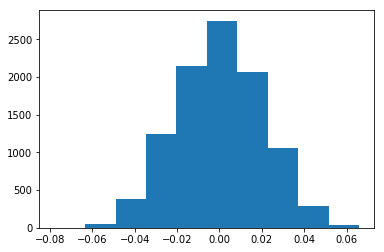

Mean difference between the xgb_accurcies and svc_accuracies is 0.0012195121951219523.


In [42]:
#The best classifiers seems to be XGBClassifier and SVC, let's make signifiance test
svc_accuracies=models_hundred_trials[1]
xgb_accuracies=models_hundred_trials[2]


mean_difference = np.mean(models_hundred_trials[1])-np.mean(models_hundred_trials[2])
all_values=svc_accuracies+xgb_accuracies

mean_differences=[]
for i in range (10000):
    group_a=[]
    group_b=[]
    for v in all_values:
        random_value=np.random.rand()
        if random_value>=0.5:
            group_a.append(v)
        else: 
            group_b.append(v)
    mean_grp_a=np.mean(group_a)
    mean_grp_b=np.mean(group_b)
    iteration_mean_difference=mean_grp_b-mean_grp_a
    mean_differences.append(iteration_mean_difference)

plt.hist(mean_differences)
plt.show()
print("Mean difference between the xgb_accurcies and svc_accuracies is {}.".format(mean_difference))

        

* Ideally, the number of times we re-randomize the groups that each data point belongs to matches the total number of possible permutations. Usually, the number of total permutations is too high for even powerful supercomputers to calculate within a reasonable time frame. While we'll use 100 iterations for now since.
Since we'll be randomizing the groups each value belongs to, we created a list named all_values that contains just the models accuracies.

We need to first count up how frequently each value in the list, mean_differences, occurs. 


In [43]:
sampling_distribution={}
for m in mean_differences:
    if sampling_distribution.get(m, False):
        inc=sampling_distribution[m]
        sampling_distribution[m]=inc+1
    else:
        sampling_distribution[m]=1

#Count up how frequently each value
frequencies=[]
i=0
for key,sample in sampling_distribution.items():
    i+=1
    if key==mean_difference:
        frequencies.append(sample)
s=np.sum(frequencies)
p_value=s/10000

print("P_value of our test is {} < 0.05 so consequently XGB is a better predicition model than SVC.".format(p_value))


P_value of our test is 0.0039 < 0.05 so consequently XGB is a better predicition model than SVC.


In [44]:
# Import 'GridSearchCV' and 'make_scorer'
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer


# Create the parameters list I wish to tune
parameters = {'base_score': [0.5], 'colsample_bylevel': [1], 'colsample_bytree': [1], 'gamma': [0], 'learning_rate': [0.1],
              'max_delta_step': [0], 'max_depth': [3,30], 'min_child_weight': [1], 'n_estimators': [100], 
              'nthread': [-1], 'objective': ['multi:softprob'], 'reg_alpha':[0], 'reg_lambda': [1], 'scale_pos_weight': [1],
              'seed': [82], 'subsample': [0.95]} 

# Initialize the classifier
clf = xgb.XGBClassifier(seed=2)

# Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score,average='weighted')

# Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(clf,
                        scoring=f1_scorer,
                        param_grid=parameters,
                        cv=5)

# Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train,y_train)

# Get the estimator
clf = grid_obj.best_estimator_
print (clf)

# Report the final F1 score for training and testing after parameter tuning
f1, acc = predict_labels(clf, X_train, y_train)
print ("F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc))
    
f1, acc = predict_labels(clf, X_test, y_test)
print ("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc))

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=82, silent=True, subsample=0.95)
Made predictions in 0.0000 seconds
F1 score and accuracy score for training set: 1.0000 , 1.0000.
Made predictions in 0.0156 seconds
F1 score and accuracy score for test set: 0.7479 , 0.7439.


# Prediction returned

In [45]:
Test=pd.read_csv("C:/Users/Amine/Desktop/Amine/Data science/Data Science 20182019/Machine learning challenge/test.csv", delimiter=",")

display(Test.head())
#We'll add one column for each categories of the column 'color' and drop it
dummy_color = pd.get_dummies(Test["color"], prefix="col")
Test = pd.concat([Test, dummy_color], axis=1)
Test=Test.drop(['color'],axis=1)
y_pred = clf.predict(Test)
d = {'id': Test['id'], 'type': y_pred}
Prediction = pd.DataFrame(data=d)
print(Prediction)

Prediction.to_csv("C:/Users/Amine/Desktop/Amine/Data science/Data Science 20182019/Machine learning challenge/sample_submission.csv",sep=';',encoding='utf-8', index=False)

,id,bone_length,rotting_flesh,hair_length,has_soul,color
0,647,0.514430,0.308411,0.533296,0.450843,white
1,2,0.467875,0.354330,0.811616,0.791225,black
2,777,0.541181,0.370581,0.791226,0.482913,white
3,507,0.272523,0.389352,0.164074,0.594088,white
4,204,0.350838,0.454637,0.783001,0.674479,clear


     id    type
0   647  Goblin
1     2   Ghoul
2   777   Ghoul
3   507  Goblin
4   204   Ghoul
5    47   Ghost
6   294  Goblin
7   133   Ghost
8   247  Goblin
9   614   Ghoul
10   93   Ghoul
11  107   Ghoul
12  627   Ghoul
13  323  Goblin
14  804  Goblin
15   71   Ghoul
16    7  Goblin
17  846   Ghost
18  701  Goblin
19  218  Goblin
20  358  Goblin
21  325  Goblin
22  754  Goblin
23  685  Goblin
24  651   Ghost
25  237   Ghoul
26  215  Goblin
27  575   Ghoul
28   96  Goblin
29  877   Ghoul
..  ...     ...
70  897   Ghoul
71  165   Ghoul
72  197   Ghoul
73  287  Goblin
74  820  Goblin
75  447   Ghost
76  113   Ghost
77    8  Goblin
78  450   Ghost
79  654  Goblin
80   25   Ghoul
81  397   Ghoul
82  262   Ghost
83   23   Ghoul
84  394   Ghoul
85   85   Ghoul
86  637  Goblin
87  351   Ghoul
88   54  Goblin
89  369  Goblin
90  199   Ghost
91  506   Ghoul
92  584   Ghoul
93  545  Goblin
94  855   Ghoul
95  772   Ghoul
96  630  Goblin
97   35   Ghoul
98  189   Ghost
99  115   Ghoul

[100 ro